<a href="https://colab.research.google.com/github/dngg6688/cupoy_chatgpt_20230827/blob/main/original/20230827/image_gpt_for_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 參考資料
- Huggingface各模型：https://huggingface.co/
- Image-GPT：https://huggingface.co/docs/transformers/main/en/model_doc/imagegpt#imagegpt

In [ ]:
!pip install openai transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 88.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.1 MB/s eta 0:00:00


In [ ]:
import tqdm
import numpy as np
from datasets import load_dataset
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
device = "cuda" if torch.cuda.is_available else "cpu"

In [ ]:
# Step1. 匯入圖片
datasets = load_dataset("rokmr/pets")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/900 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/150 [00:00<?, ? examples/s]

2


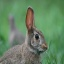

In [ ]:
# Step2. EDA
import matplotlib.pyplot as plt
print(datasets["train"][700]["label"])
datasets["train"][700]["image"]

In [ ]:
# Step3. 匯入圖片前處理、預訓練模型
from transformers import AutoImageProcessor, ImageGPTForImageClassification

model_checkpoint = "openai/imagegpt-small"
image_preprocessor = AutoImageProcessor.from_pretrained(model_checkpoint)
model = ImageGPTForImageClassification.from_pretrained(model_checkpoint, num_labels = 3).to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Some weights of ImageGPTForImageClassification were not initialized from the model checkpoint at openai/imagegpt-small and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainImage = [datasets["train"][i]["image"] for i in range(datasets["train"].__len__()) if datasets["train"][i]["image"].getbands().__len__() == 3]
testImage = [datasets["test"][i]["image"] for i in range(datasets["test"].__len__()) if datasets["test"][i]["image"].getbands().__len__() == 3]
trainLabel = [datasets["train"][i]["label"] for i in range(datasets["train"].__len__()) if datasets["train"][i]["image"].getbands().__len__() == 3]
testLabel = [datasets["test"][i]["label"] for i in range(datasets["test"].__len__()) if datasets["test"][i]["image"].getbands().__len__() == 3]

In [ ]:
# Step5. 資料前處理
trainImage = [image_preprocessor(i, return_tensors="pt")["input_ids"][0, :].tolist() for i in trainImage]
testImage = [image_preprocessor(i, return_tensors="pt")["input_ids"][0, :].tolist() for i in testImage]

In [ ]:
trainImage[0].__len__()

1024

In [ ]:
def transform_dataloader(img, label, batch_size):
  dataset = TensorDataset(
      torch.LongTensor(img),
      torch.LongTensor(label)
  )
  return DataLoader(dataset, batch_size = batch_size, shuffle = True)

trainDataLoader = transform_dataloader(img = trainImage, label = trainLabel, batch_size = 4)
testDataLoader = transform_dataloader(img = testImage, label = testLabel, batch_size = 4)

In [ ]:
# Step6 模型訓練與評估
epochs = 20
trainLossList, valiLossList = list(), list()

for epoch in range(epochs):
  trainLoss, valiLoss = list(), list()

  for oneImg, oneLabel in tqdm.tqdm(trainDataLoader):
    yhat = model(oneImg.to(device)).logits
    loss = loss_func(yhat, oneLabel.to(device))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    trainLoss.append(loss.cpu().item())
  trainLossList.append(sum(trainLoss) / len(trainLoss))

  for oneImg, oneLabel in tqdm.tqdm(testDataLoader):
    yhat = model(oneImg.to(device)).logits
    loss = loss_func(yhat, oneLabel.to(device))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    valiLoss.append(loss.cpu().item())
  valiLossList.append(sum(valiLoss) / len(valiLoss))
  print("Epoch: {}, Train Loss: {}, Validation Loss: {}".format(epoch, trainLossList[-1], valiLossList[-1]))

100%|██████████| 38/38 [00:38<00:00,  1.02s/it]


Epoch: 0, Train Loss: 0.8863175279233191, Validation Loss: 0.8740363944517938


 54%|█████▍    | 122/225 [02:09<01:49,  1.06s/it]

In [ ]:
valiLossList

[0.9196018576622009,
 0.7989718294457385,
 0.5277873544316543,
 0.4025479770559621,
 0.3604388907061596,
 0.10974495752261167,
 0.20674442371206456,
 0.15174617556132083,
 0.28585053586376535,
 0.03593232096682186,
 0.12631633515526405,
 0.05956136501481524,
 0.06470347174495385,
 0.021836403469071803,
 0.09106298939686415,
 0.0423935141971972,
 0.007003147857942263,
 0.020344944960195215,
 0.021381965576593803,
 0.1305714974235008]